In [1]:
# Imports
import random
import string
import tempfile
import shutil
import subprocess as sp
import os

from PIL import Image
from torch import nn as nn
from torch import Generator
from torch.utils.data import random_split,DataLoader
# TODO: Currently assumes that pytest runs from project root
from util.car_dataset import check_dir, check_file, CarDataset, DatasetError
from networks.common import *
from networks.CNNbase import CNNBasic

In [2]:
root = os.getcwd()
print(os.getcwd())

/home/akshay.viswakumar/dl-based-sensor-calib


In [3]:
# Set Up Paths and Metadata for Storing Values
test_class = "Regularization"
test_name = "alpha05"
epochs = 21
checkpoint_path = os.path.join(root,"Test-Results",test_class,test_name)

In [4]:
# Helper Functions
def rand_string(length=5):
    return ''.join(random.choices(string.ascii_letters +
        string.digits, k=length))

def loaded_dataset(temp_dir):
    '''
    Loads the car_dataset and returns the CarDataset object.
    '''
    image_folder_list = ['0_Frames','1_Frames','2_Frames','3_Frames']
    label_file_list = ['0.txt','1.txt','2.txt','3.txt']
    #image_folder_list = ['0_Frames']
    #label_file_list = ['0.txt']
    car_data = CarDataset(temp_dir,image_folder_list,label_file_list)
    car_data.drop_nan()

    return car_data

def dataset_loader(loaded_dataset):
    length = len(loaded_dataset)
    split_set = random_split(loaded_dataset,[round(0.80*length)
                ,round(0.20*length)],generator=Generator().manual_seed(42))
    train_loader = DataLoader(split_set[0],batch_size=20)
    test_loader = DataLoader(split_set[1],batch_size=20)
    '''
    Lowering values to sane levels to help run tests on github
    runners. Ideally on local GPU (4GB) 80/20 split with batch size of
    30 works well.
    '''
    return (train_loader,test_loader)

def network(alpha=0):
    network = CNNBasic(alpha)
    network = network.to(get_device())
    network.double()
    return network

In [5]:
# Load Data
data = loaded_dataset(os.path.join(root,"dummy"))

In [6]:
# Split Dataset
datasets = dataset_loader(data)

In [7]:
# Initialize Network
net = network(alpha=0.5)

In [8]:
# Train
train = datasets[0]
test = datasets[1]
print("Start Training")
losses = run_training(net,train,test,epochs,get_device(),checkpoint_path,test_name,checkpoint_freq=5)

0it [00:00, ?it/s]

Start Training


149it [02:08,  1.16it/s]


Num = 38
Len = 742
Test Set Average Loss 0.001047
Train Epoch: 0	Train Loss: 0.001818 Test Loss:0.001047


In [9]:
# Save Loss Files
save_stats(losses[0],os.path.join(checkpoint_path,'train_loss.pkl')) # Train loss
save_stats(losses[1],os.path.join(checkpoint_path,'test_loss.pkl')) # Test Loss

In [10]:
import matplotlib.pyplot as plt

def plot_losses(test,train):
    plt.figure()
    plt.grid()
    plt.plot(train,label='train')
    plt.plot(test,label='test')
    plt.legend()

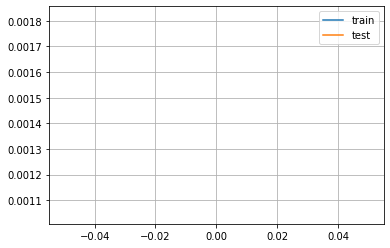

In [11]:
plot_losses(losses[0],losses[1])

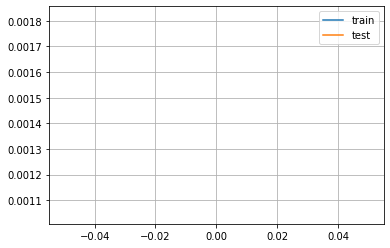

In [12]:
# Just a Backup Test
plot_losses(load_stats(os.path.join(checkpoint_path,'train_loss.pkl')),load_stats(os.path.join(checkpoint_path,'test_loss.pkl')))